# Finding the invariant mass

## Captain log

161221-1 (Marie) 

> * Still need to understand the track loop, as it is it reads only the two track events
> * Some events with isCMUL==1 have none or more than 2 tracks, how to extract the invariant mass ? Need to implement other cuts, like nMuons==2, and sum the energies and impulsions for each muon

161221-2 (Marie) 

> * Cut on nMuons, sum on E and P
> * Scaled the invariant mass in order to get countsper 100Mev/c^2
> * Plot coherent with the [Alice article](https://www.sciencedirect.com/science/article/pii/S0370269311011270) from the bibliography

221221-1 (Marie)
> * Changed and implemented Minv formula using the costheta already implemented function
> * Changed everything involving the sum of impulsions because the arrays were not properly summed
> * Now compute Minv for every combination of all the tracks in one event
> * Need to implement the mixed events technique to get uncorrelated data and see the peak over the background (see the [article](https://www.sciencedirect.com/science/article/pii/S0168900201015583)) : is it best to do it in the Minv loop or in a whole new and dedicated loop ?

## Initialization

Libraries and root files.

> Be careful with the statistics and the runtime

Not enough statistic in run 290223 (3,7Mo)

Too much in runs 291375 (411Mo), 291397 (891M, biggest file, best statistics but long runtime)

Prefer run 291690 (50.4Mo, quickest) to check the algorithm, 291944 (133Mo) to get a first idea with more statistics

> Decomment the one you want to download with curl

In [93]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import boost_histogram as bh

In [94]:
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=290223/AnalysisResults.root' > run290223.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291397/AnalysisResults.root' > run291397.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291375/AnalysisResults.root' > run291375.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291944/AnalysisResults.root' > run291944.data.root
#!curl 'https://cernbox.cern.ch/index.php/s/r7VFXonK39smzKP/download?path=291690/AnalysisResults.root' > run291690.data.root


In [95]:
file = uproot.open("run291944.data.root")
events = file["eventsTree"]

## Function declaration

On définit comme précédemment quelques fonctions pour calculer la pseudo-rapidité :

In [96]:
def mag(px:float,py:float,pz:float):
    """Returns the norm of the 3-vector (px,py,pz)."""
    return math.sqrt(px*px+py*py+pz*pz)

def costheta(px:float,py:float,pz:float):
    """Returns the cos(theta) of the 3 vector (px,py,pz)."""
    ptot = mag(px,py,pz)
    return 1.0 if ptot == 0.0 else pz/ptot

def invmass(E1:float, E2:float, impulsion12):
    """Returns the invariant mass from (p1+p2)^2"""
    ct12 = costheta(impulsion12[0],impulsion12[1],impulsion12[2])
    return math.sqrt(2*E1*E2*(1-ct12))


def eta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = costheta(px,py,pz)
    if ct*ct < 1:
        return -0.5* math.log( (1.0-ct)/(1.0+ct) )
    if pz == 0: 
        return 0
    if pz>0: 
        return 10E10
    else:
        return -10E20

## Invariant Mass

### Histograms

In [97]:
hMinv = hist.Hist(hist.axis.Regular(bins=10000,start=0,stop=1000,name='$Minv$'))

### Invariant Mass extraction

In [98]:
nofTracks1=0 
nofTracks2=0 
nofEvents=0  
E1 = 0
E2 = 0
charge1 = 0
charge2 = 0
P1 = [0,0,0]
P2 = [0,0,0]

for m in events.iterate(["nMuons","isCMUL","Muon_E","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.isCMUL>0]:
        if event.nMuons==2:
            nofEvents+=1
            tracks = event["Muon"].to_list()
            for t in tracks:
                    nofTracks1+=1
                    charge1 = t["Charge"]
                    E1 = t["E"]
                    P1 = [t["Px"],t["Py"],t["Pz"]]
                    for t2 in tracks:
                        nofTracks2+=1
                        charge2 = t2["Charge"]
                        if (nofTracks2 > nofTracks1 and charge2 != charge1):
                            E2 = t2["E"]
                            P2 = [t["Px"],t["Py"],t["Pz"]]
                            Pdimuon = [x + y for x, y in zip(P1,P2)]
                            hMinv.fill(invmass(E1,E2,Pdimuon)*0.01)
                            E2 = 0
                            P2 = [0,0,0]
                    E1 =0
                    P1 = [0,0,0]        

### Plot

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x17f0533a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

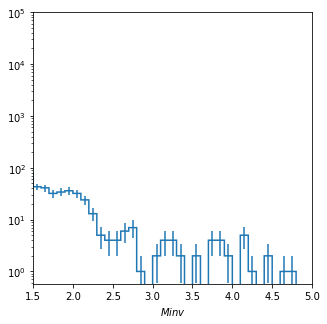

In [99]:
plt.figure(figsize=(5,5))
plt.yscale("log")
#plt.xscale("log")
plt.xlim(1.5,5)
hMinv.plot()